In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

torch.backends.cudnn.benchmark = True

In [3]:
# Определяем трансформации для предобработки
transform = transforms.Compose(
    [transforms.Resize((112, 112)),    # Изменяем размер изображения до 224x224
     transforms.ColorJitter(),
     transforms.RandomHorizontalFlip(),    # Отражаем изображение по горизонтали
     transforms.RandomRotation(10),
     transforms.RandomGrayscale(), # Вращаем изображение на случайный угол до 10 градусов
     transforms.ToTensor(),    # Преобразуем изображение в тензор
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])    # Нормализуем изображение

In [4]:
val_transform = transforms.Compose(
    [transforms.Resize((112, 112)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [5]:
train_dataset = ImageFolder(root='./archive/dataset/training_set', transform=transform)
val_dataset = ImageFolder(root='./archive/dataset/test_set', transform=val_transform)

In [6]:
batch_sz = 16
train_loader = DataLoader(train_dataset, batch_size=batch_sz, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_sz, shuffle=True, pin_memory=True)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(2,2)
        self.conv0_0 = nn.Conv2d(3, 64, 7, stride=2, padding=0)
        
        self.conv1_0 = nn.Conv2d(64, 128, 3, stride=1, padding=0)
        self.norm1_0 = nn.GroupNorm(32, 128)
        
        self.conv2_0 = nn.Conv2d(128, 128, 3, stride=1, padding=0)
        self.norm2_0 = nn.GroupNorm(32, 128)
        self.conv2_1 = nn.Conv2d(128, 256, 3, stride=1, padding=0)
        self.norm2_1 = nn.GroupNorm(64, 256)
        
        self.conv3_0 = nn.Conv2d(256, 256, 3, stride=1, padding=0)
        self.norm3_0 = nn.GroupNorm(64, 256)

        
        self.conv4_0 = nn.Conv2d(256, 512, 3, stride=1, padding=0)
        
        self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(512, 32)
        self.dropout = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(32, 2)
        
        
        
    def forward(self, x):
        

        out = self.conv0_0(x)
        out = self.act(out)
        #out = self.maxpool(out)

        out = self.conv1_0(out)
        out = self.norm1_0(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv2_0(out)
        out = self.norm2_0(out)
        out = self.act(out)
        out = self.conv2_1(out)
        out = self.norm2_1(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv3_0(out)
        out = self.norm3_0(out)
        out = self.act(out)

        out = self.conv4_0(out)
        out = self.act(out)
    

        
        
        out = self.adaptivepool(out)
        out = self.flatten(out)
        
        out = self.linear1(out)
        out = self.dropout(out)
        out = self.linear2(out)
        out = self.act(out)
        

        return out        

In [8]:
torch.cuda.empty_cache()
net = Net().to(device)

In [9]:
for name, param in net.named_parameters():
    print(name, param.shape)

conv0_0.weight torch.Size([64, 3, 7, 7])
conv0_0.bias torch.Size([64])
conv1_0.weight torch.Size([128, 64, 3, 3])
conv1_0.bias torch.Size([128])
norm1_0.weight torch.Size([128])
norm1_0.bias torch.Size([128])
conv2_0.weight torch.Size([128, 128, 3, 3])
conv2_0.bias torch.Size([128])
norm2_0.weight torch.Size([128])
norm2_0.bias torch.Size([128])
conv2_1.weight torch.Size([256, 128, 3, 3])
conv2_1.bias torch.Size([256])
norm2_1.weight torch.Size([256])
norm2_1.bias torch.Size([256])
conv3_0.weight torch.Size([256, 256, 3, 3])
conv3_0.bias torch.Size([256])
norm3_0.weight torch.Size([256])
norm3_0.bias torch.Size([256])
conv4_0.weight torch.Size([512, 256, 3, 3])
conv4_0.bias torch.Size([512])
linear1.weight torch.Size([32, 512])
linear1.bias torch.Size([32])
linear2.weight torch.Size([2, 32])
linear2.bias torch.Size([2])


In [10]:
torch.cuda.empty_cache()

for layer in net.modules():
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        layer.reset_parameters()

In [11]:
optimizer = optim.Adam(net.parameters(), lr=5e-5, betas=(0.9, 0.999))
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=2e-4)
criterion = nn.CrossEntropyLoss()
criterion.to(device)

CrossEntropyLoss()

In [12]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1) 
    return answer.mean()

Epoch # 1 [500]  loss: 3.37211  accuracy: 0.57925 (4634/8000)
Epoch # 2 [500]  loss: 3.03353  accuracy: 0.66787 (5343/8000)
Epoch # 3 [500]  loss: 2.82383  accuracy: 0.71400 (5712/8000)
Epoch # 4 [500]  loss: 2.65902  accuracy: 0.73700 (5896/8000)
Epoch # 5 [500]  loss: 2.50219  accuracy: 0.76500 (6120/8000)
Epoch # 6 [500]  loss: 2.29380  accuracy: 0.78538 (6283/8000)
Epoch # 7 [500]  loss: 2.22596  accuracy: 0.79325 (6346/8000)
Epoch # 8 [500]  loss: 2.07626  accuracy: 0.80975 (6478/8000)
Epoch # 9 [500]  loss: 2.04426  accuracy: 0.81612 (6529/8000)
Epoch # 10 [500]  loss: 1.89068  accuracy: 0.83175 (6654/8000)
Epoch # 11 [500]  loss: 1.85506  accuracy: 0.83525 (6682/8000)
Epoch # 12 [500]  loss: 1.79215  accuracy: 0.84500 (6760/8000)
Epoch # 13 [500]  loss: 1.68645  accuracy: 0.85550 (6844/8000)
Epoch # 14 [500]  loss: 1.61355  accuracy: 0.86725 (6938/8000)
Epoch # 15 [500]  loss: 1.55461  accuracy: 0.87000 (6960/8000)
Epoch # 16 [500]  loss: 1.47431  accuracy: 0.87562 (7005/8000)
E

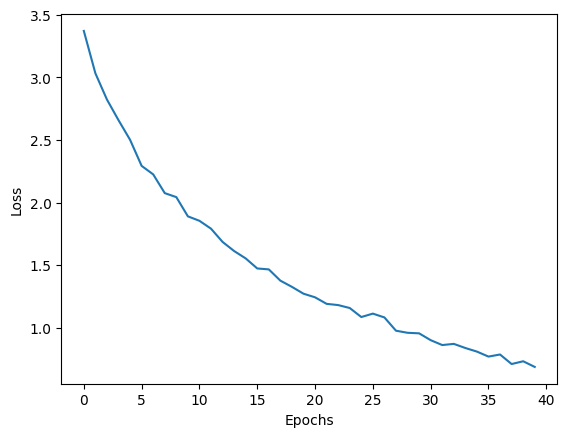

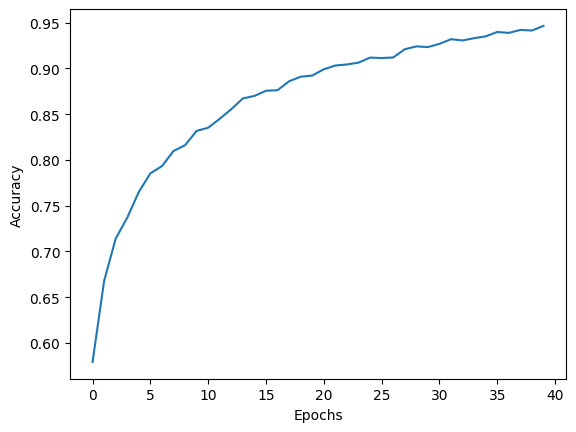

In [13]:
train_loss = []
acc = []

# Обучаем модель
for epoch in range(40):
    running_loss = 0.0
    print("Epoch #", epoch+1, end = " ")
    
    total_correct = 0
    total_images = 0
    
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs = inputs.to(device)  # переводим данные на GPU
        labels = labels.to(device)  # переводим данные на GPU

        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()        
        # вычисление точности
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        
        loss_item = loss.item()
        running_loss += loss_item     
        
        #scheduler.step()
        
        if i % (8000//batch_sz) == (8000//batch_sz - 1):    # печатаем каждые 125 батчей
            
            train_loss.append(running_loss / 100)
            acc.append(total_correct/total_images)
            
            print('[%2d]  loss: %.5f  accuracy: %.5f (%.0f/%.0f)' % (i + 1, running_loss / 100, total_correct/total_images, total_correct, total_images))

            running_loss = 0.0

# выводим график лосса
plt.plot(train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [14]:
ac = []

def test_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            ac.append(correct/total)
            #print('Accuracy: ', correct/total)
    accuracy = 100 * correct / total
    return accuracy

In [15]:
net.eval() # применение метода eval к модели
test_model(net, val_loader)

90.15

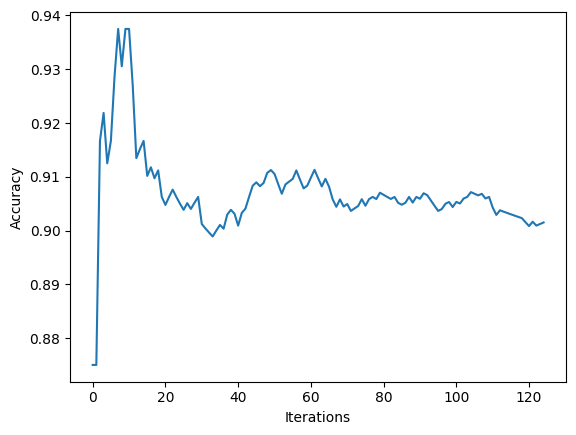

In [16]:
plt.plot(ac)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()

In [17]:
net.eval()

Net(
  (act): LeakyReLU(negative_slope=0.2)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0_0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
  (conv1_0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (norm1_0): GroupNorm(32, 128, eps=1e-05, affine=True)
  (conv2_0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (norm2_0): GroupNorm(32, 128, eps=1e-05, affine=True)
  (conv2_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (norm2_1): GroupNorm(64, 256, eps=1e-05, affine=True)
  (conv3_0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (norm3_0): GroupNorm(64, 256, eps=1e-05, affine=True)
  (conv4_0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (adaptivepool): AdaptiveAvgPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=512, out_features=32, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=32, out_features

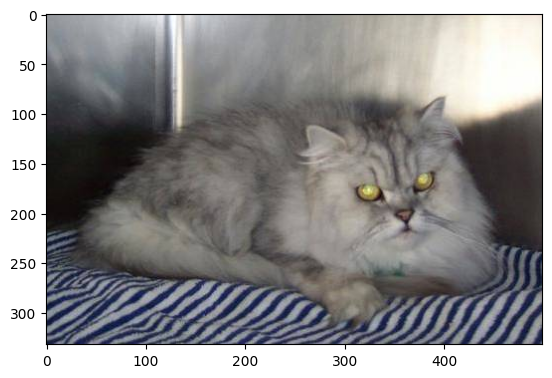

КОШКА с вероят: 99.98%
tensor([[9.9980e-01, 2.0276e-04]], device='cuda:0')


In [27]:
img_path = "cats_vs_dogs/validation/cats/cat.2480.jpg"

img = Image.open(img_path)

plt.imshow(img)
plt.show()

img_tensor = val_transform(img).to(device)

with torch.no_grad():
    output = net(img_tensor.unsqueeze(0))
    
predicted_class = torch.argmax(output).item()

probs = F.softmax(output, dim=1)

cat_prob = probs[0][0].item()  # вероятность класса кошки
dog_prob = probs[0][1].item()  # вероятность класса собаки

if predicted_class == 0: 
    print('КОШКА с вероят: %.2f%%' % (cat_prob*100)) 
else: 
    print('СОБАКА с вероят: %.2f%%' % (dog_prob*100))

print(probs)

In [20]:
torch.save(net.state_dict(), 'net_85,7.pth')